# Predicting the right side of a face from the given left side
## Library imports

In [11]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)
print('NumPy version: ', np.__version__)

TensorFlow version: 2.3.0
NumPy version:  1.18.5


## 1. Acquire a dataset for training
CelebA is a great dataset for all kinds of faces with different features, so it only makes sense to use for training

In [13]:
celeba_bldr = tfds.builder('celeb_a')
celeba_bldr.download_and_prepare()
celeba = celeba_bldr.as_dataset(shuffle_files=False)
print(celeba.keys())

celeba_train = celeba['train']
celeba_valid = celeba['validation']
celeba_test = celeba['test']

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.0.incompleteIYSFI1/celeb_a-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.0.incompleteIYSFI1/celeb_a-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/celeb_a/2.0.0.incompleteIYSFI1/celeb_a-test.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet
ERROR:absl:Statistics generation doesn't work for nested structures yet


ERROR:absl:Statistics generation doesn't work for nested structures yet
ERROR:absl:Statistics generation doesn't work for nested structures yet


ERROR:absl:Statistics generation doesn't work for nested structures yet
ERROR:absl:Statistics generation doesn't work for nested structures yet



Dataset celeb_a downloaded and prepared to /root/tensorflow_datasets/celeb_a/2.0.0. Subsequent calls will reuse this data.
dict_keys(['test', 'train', 'validation'])


## 2. Define the dataset image preprocessing function
### 1. Define the function

In [14]:
def preprocess(example, size=(64, 64)):
    image = example['image']
    height, width = size
    image_cropped = tf.image.crop_to_bounding_box(
        image, offset_height=20, offset_width=0,
        target_height=178, target_width=178)
    image_resized = tf.image.resize(
        image_cropped, size=size)
    left_side = tf.image.crop_to_bounding_box(
        image_resized, offset_height=0, offset_width=0,
        target_height=height, target_width=int(width / 2))
    right_side = tf.image.crop_to_bounding_box(
        image_resized, offset_height=0, offset_width=int(width / 2),
        target_height=height, target_width=int(width / 2))
    #print(left_side.shape)
    return (left_side / 255.0, right_side / 255.0)

### 2. Check if preprocessing returns right and left halves of an image

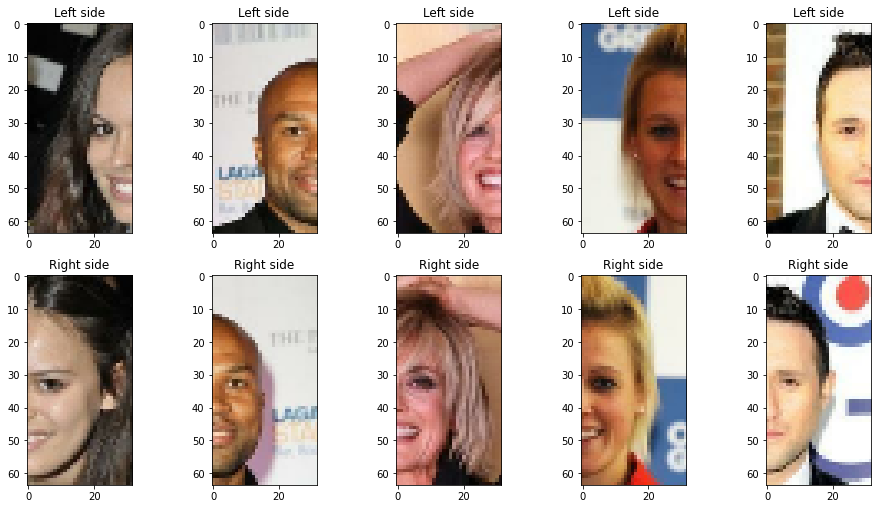

In [15]:
## Take and preprocess 5 examples:
examples = []
for example in celeba_train.take(5):
    examples.append(preprocess(example))

fig = plt.figure(figsize=(16, 8.5))

for column, (left_side, right_side) in enumerate(examples):
    ax = fig.add_subplot(2, 5, 1 + column)
    ax.set_title('Left side', size=12)
    ax.imshow(left_side)
    ax = fig.add_subplot(2, 5, 6 + column)
    ax.set_title('Right side', size=12)
    ax.imshow(right_side)

## 3. Preprocess the dataset

In [16]:
tf.random.set_seed(1)

def count_items(ds):
    n = 0
    for _ in ds:
        n += 1
    return n

TRAIN_EXAMPLE_NUM = count_items(celeba_train)
BATCH_SIZE = 64
BUFFER_SIZE = 16000
IMAGE_SIZE = (64, 64)
steps_per_epoch = np.ceil(TRAIN_EXAMPLE_NUM / BATCH_SIZE)
print(steps_per_epoch)

ds_train = celeba_train.map(
    lambda x: preprocess(x, size=IMAGE_SIZE))
ds_train = ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train = ds_train.batch(BATCH_SIZE)

ds_valid = celeba_valid.map(
    lambda x: preprocess(x, size=IMAGE_SIZE))
ds_valid = ds_valid.batch(BATCH_SIZE)

2544.0


## 4. Define the model architecture
### 1. Add convolutional and pooling layers for feature extraction

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(
        256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
])

model.compute_output_shape(input_shape=(None, 64, 32, 3))

TensorShape([None, 4, 2, 256])

### 2. Flatten the resulting output before passing it to the dense part of the network

In [18]:
model.add(tf.keras.layers.Flatten())
model.compute_output_shape(input_shape=(None, 64, 32, 3))

TensorShape([None, 2048])

### 3. Add a dense layer

In [19]:
model.add(tf.keras.layers.Dense(
    units=1024, activation='relu'))
model.compute_output_shape(input_shape=(None, 64, 32, 3))

TensorShape([None, 1024])

### 4. Reshape the output from the dense layer before deconvolution

In [20]:
model.add(tf.keras.layers.Reshape(target_shape=(4, 2, 128)))
model.compute_output_shape(input_shape=(None, 64, 32, 3))

TensorShape([None, 4, 2, 128])

### 5. Add deconvolutional layers

In [21]:
model.add(tf.keras.layers.Conv2DTranspose(
    64, (3, 3), strides=(2, 2), padding="same", activation="relu"))
model.compute_output_shape(input_shape=(None, 64, 32, 3))

TensorShape([None, 8, 4, 64])

In [22]:
model.add(tf.keras.layers.Conv2DTranspose(
    32, (3, 3), strides=(2, 2), padding="same", activation="relu"))
model.compute_output_shape(input_shape=(None, 64, 32, 3))

TensorShape([None, 16, 8, 32])

In [23]:
model.add(tf.keras.layers.Conv2DTranspose(
    16, (3, 3), strides=(2, 2), padding="same", activation="relu"))
model.compute_output_shape(input_shape=(None, 64, 32, 3))

TensorShape([None, 32, 16, 16])

In [24]:
model.add(tf.keras.layers.Conv2DTranspose(
    3, (3, 3), strides=(2, 2), padding="same", activation="relu"))
model.compute_output_shape(input_shape=(None, 64, 32, 3))

TensorShape([None, 64, 32, 3])

## 5. Build the model

In [25]:
tf.random.set_seed(1)
model.build(input_shape=(None, 64, 32, 3))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 8, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 8, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 8, 128)        7

## 6. Train the model for several epochs
We need to make sure that training the model actually yields useful results

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

history = model.fit(ds_train, validation_data=ds_valid,
                    epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5
2544/2544 [==============================] - 118s 46ms/step - loss: 0.0476 - accuracy: 0.7466 - val_loss: 0.0522 - val_accuracy: 0.7829
Epoch 2/5
2544/2544 [==============================] - 131s 51ms/step - loss: 0.0397 - accuracy: 0.7750 - val_loss: 0.0505 - val_accuracy: 0.7871
Epoch 3/5
2544/2544 [==============================] - 133s 52ms/step - loss: 0.0382 - accuracy: 0.7776 - val_loss: 0.0439 - val_accuracy: 0.7827
Epoch 4/5
2544/2544 [==============================] - 134s 53ms/step - loss: 0.0374 - accuracy: 0.7804 - val_loss: 0.0399 - val_accuracy: 0.7916
Epoch 5/5
2544/2544 [==============================] - 129s 51ms/step - loss: 0.0367 - accuracy: 0.7821 - val_loss: 0.0388 - val_accuracy: 0.7821


## 7. Check the initial training results
### 1. Evaluate the model on the testing dataset

In [28]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE)).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1] * 100))

Test Acc: 77.96%


### 2. Visualize a group of testing examples

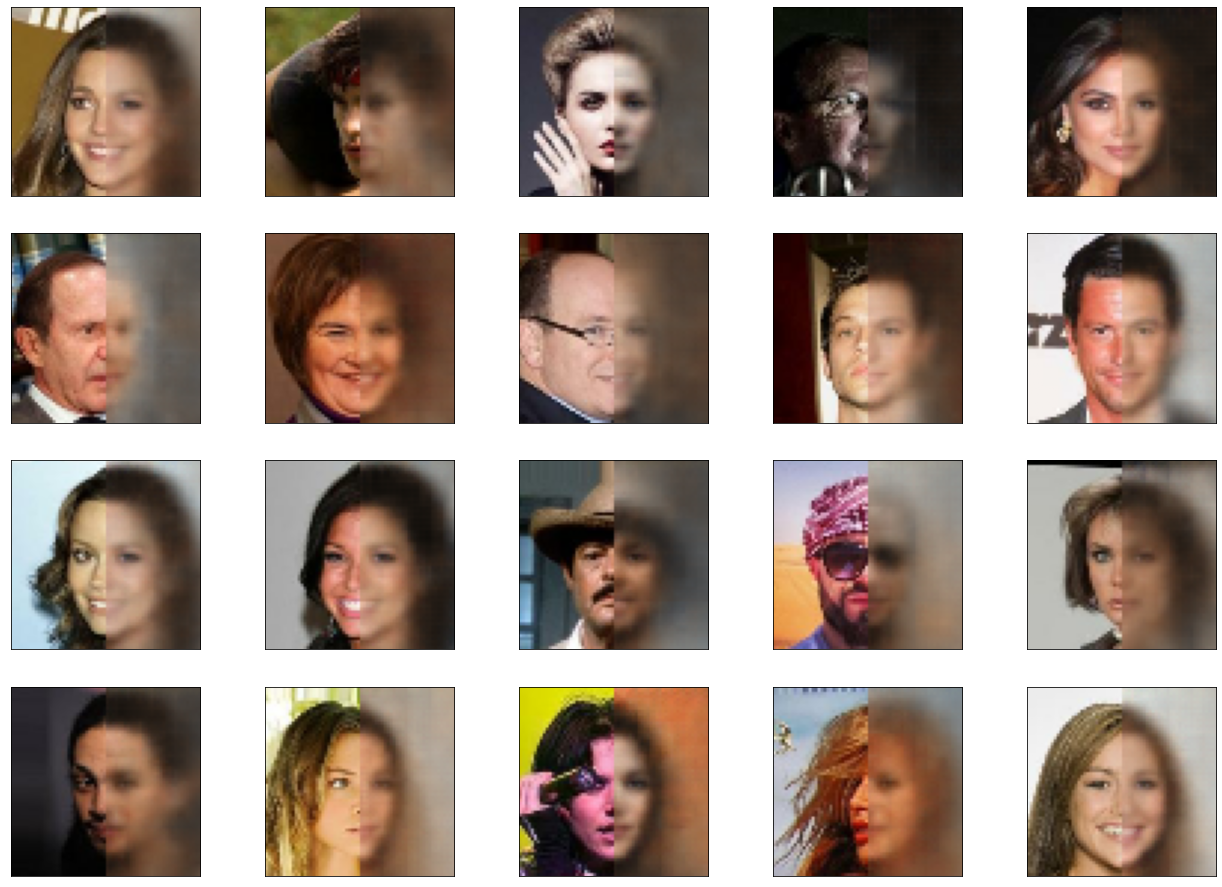

In [29]:
ds = ds_test.unbatch().take(20)

pred_rights = model.predict(ds.batch(10))

fig = plt.figure(figsize=(22, 16))
for j, example in enumerate(ds):
    ax = fig.add_subplot(4, 5, j + 1)
    ax.set_xticks([]); ax.set_yticks([])
    face = np.concatenate((example[0], pred_rights[j]), axis=1) 
    ax.imshow(face)
    
plt.show()

## 8. Train the model more and compare the results

In [30]:
history = model.fit(ds_train, validation_data=ds_valid, 
                    epochs=20, initial_epoch=5,
                    steps_per_epoch=steps_per_epoch)

Epoch 6/20
2544/2544 [==============================] - 124s 49ms/step - loss: 0.0362 - accuracy: 0.7829 - val_loss: 0.0397 - val_accuracy: 0.7859
Epoch 7/20
2544/2544 [==============================] - 134s 52ms/step - loss: 0.0357 - accuracy: 0.7835 - val_loss: 0.0381 - val_accuracy: 0.7900
Epoch 8/20
2544/2544 [==============================] - 136s 54ms/step - loss: 0.0354 - accuracy: 0.7838 - val_loss: 0.0385 - val_accuracy: 0.7897
Epoch 9/20
2544/2544 [==============================] - 135s 53ms/step - loss: 0.0350 - accuracy: 0.7838 - val_loss: 0.0380 - val_accuracy: 0.7855
Epoch 10/20
2544/2544 [==============================] - 133s 52ms/step - loss: 0.0347 - accuracy: 0.7840 - val_loss: 0.0395 - val_accuracy: 0.7939
Epoch 11/20
2544/2544 [==============================] - 134s 53ms/step - loss: 0.0345 - accuracy: 0.7834 - val_loss: 0.0382 - val_accuracy: 0.7845
Epoch 12/20
2544/2544 [==============================] - 137s 54ms/step - loss: 0.0342 - accuracy: 0.7829 - val_loss

In [31]:
ds_test = celeba_test.map(
    lambda x:preprocess(x, size=IMAGE_SIZE)).batch(32)
results = model.evaluate(ds_test, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Test Acc: 78.58%


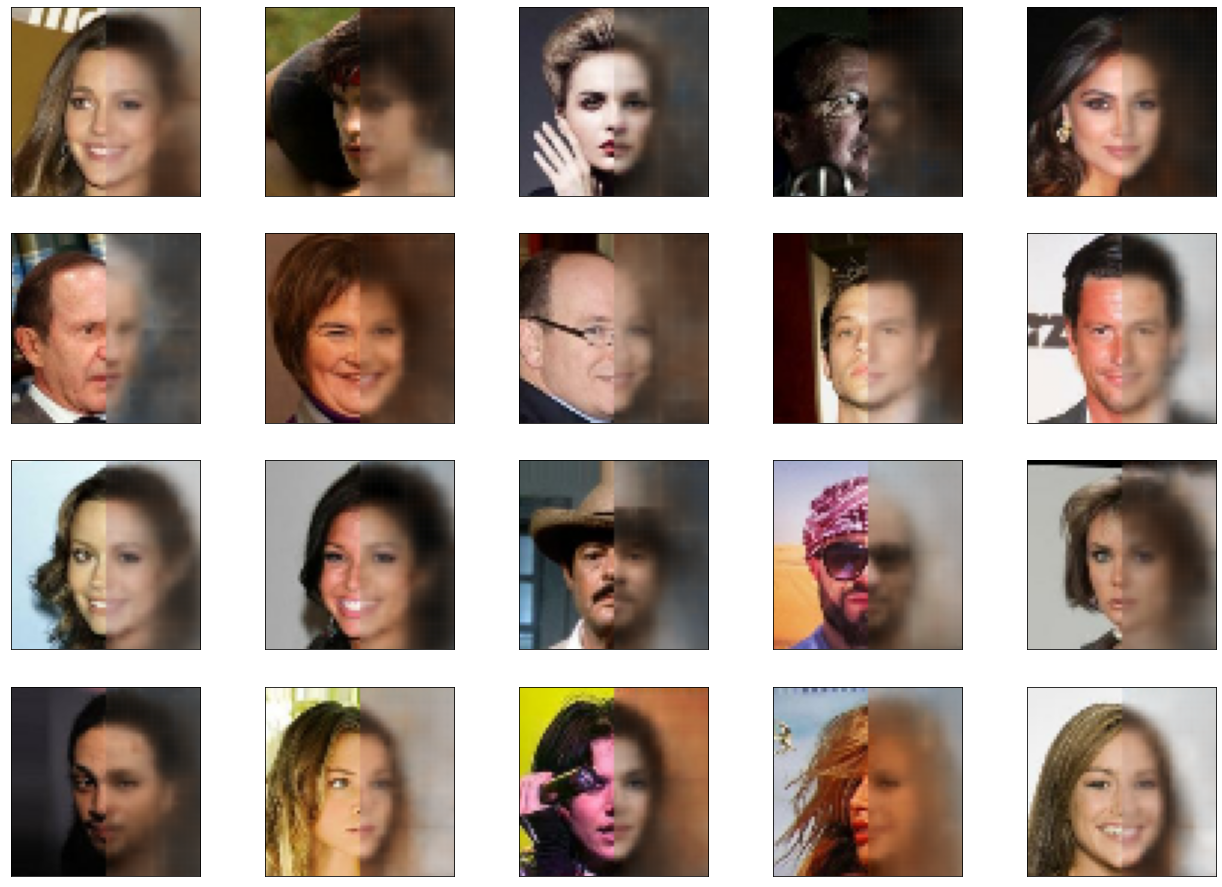

In [33]:
ds = ds_test.unbatch().take(20)

pred_rights = model.predict(ds.batch(10))

fig = plt.figure(figsize=(22, 16))
for j, example in enumerate(ds):
    ax = fig.add_subplot(4, 5, j + 1)
    ax.set_xticks([]); ax.set_yticks([])
    face = np.concatenate((example[0], pred_rights[j]), axis=1) 
    ax.imshow(face)
    
plt.show()

## 9. Conclusions
- Despite the model being quite simple, the results were quite decent in a good number of cases
- It does not take many examples to see that the model struggles with with uncommon angles, skin colours (it seems to do okay with natural tones, but apparently is too general for faces with fresh tans (reddish faces) and faces after colour correction)
- The model seems to be inconsistent with clothing and accessories, such as hats and glasses
- One of the shortcomings of the chosen dataset for this task is its great variety of backgrounds and styles (filters, colour correction), which almost definitely negatively influenced training of the model
- Surprisingly, despite all issues with skin colours, the model managed to capture the general tendency for women faces to have shadows around the eyes